In [1]:
import sys
import os
import pandas as pd
import numpy as np
import joblib
from lightgbm import LGBMClassifier
import sklearn
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc

sys.path.append(os.path.abspath('../src'))
from utils import prepare_dataset, not_train

In [2]:
model = joblib.load('../models/lgbm_model.pkl')

D:\PYTHON_PROJECTS\credit_scoring_project\venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
best_threshold = 0.3988986985559332 

**Preprocessing data for model scoring**

In [4]:
df = pd.read_csv('../data/raw/cs-training.csv', index_col=0)
df = prepare_dataset(df)
target = 'SeriousDlqin2yrs'
X_train = df.drop(columns=[target])
y_train = df[target]

**ROC**

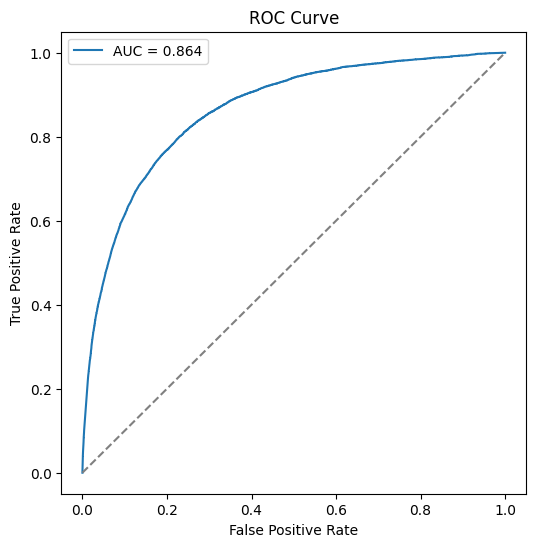

In [5]:
y_pred_prob = model.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Future importance**

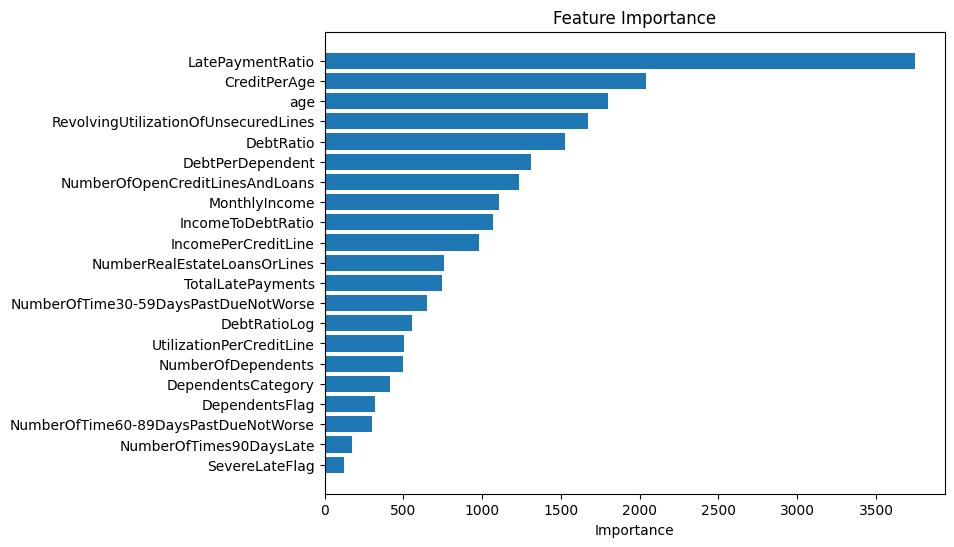

In [6]:
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8,6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


**Top risky clients**

In [7]:
top_risky = pd.DataFrame({
    'Id': X_train.index,
    'Probability': y_pred_prob
}).sort_values(by='Probability', ascending=False).head(10)

display(top_risky)

,Id,Probability
24858,24859,0.984889
17557,17558,0.984889
140188,140190,0.984889
59128,59129,0.984889
7033,7034,0.984889
127359,127361,0.984889
1977,1978,0.984889
58235,58236,0.984889
43443,43444,0.984889
147065,147067,0.984889


In [14]:
y_pred_prob = model.predict_proba(X_train)[:, 1]
best_threshold = 0.3988986985559332 
y_pred = (y_pred_prob >= best_threshold).astype(int)

print(classification_report(y_train, y_pred))
cm = confusion_matrix(y_train, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.79      0.87    139973
           1       0.21      0.78      0.33     10026

    accuracy                           0.79    149999
   macro avg       0.59      0.78      0.60    149999
weighted avg       0.93      0.79      0.84    149999

[[110144  29829]
 [  2187   7839]]


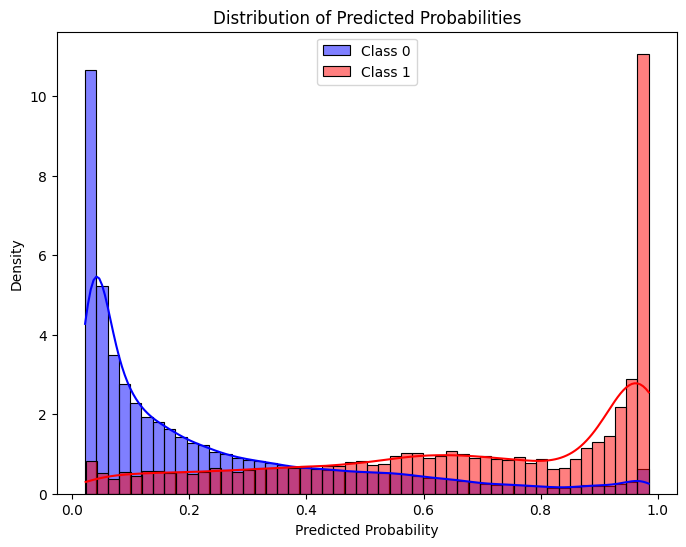

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.histplot(y_pred_prob[y_train==0], color='blue', label='Class 0', kde=True, stat="density", bins=50)
sns.histplot(y_pred_prob[y_train==1], color='red', label='Class 1', kde=True, stat="density", bins=50)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()